Download the data from
https://www.kaggle.com/hugomathien/soccer/data

%%bash

cp ~/Downloads/soccer.zip .
unzip soccer.zip

In [214]:
import sqlite3
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [3]:
country_name = ('Spain',)
spain_id = pd.read_sql_query('SELECT * FROM country WHERE name=?', conn, params=country_name).iloc[0]['id']
pd.read_sql_query('SELECT * FROM country WHERE name=?', conn, params=country_name)

,id,name
0,21518,Spain


In [18]:
t = (str(spain_id), )
data = pd.read_sql_query('SELECT *  FROM match where country_id = ?', conn, params = t)

In [19]:
def parse_xml(xml_column):
    """
    Given the name of xml_column, produces a  dataframe with
    the xml_column extracted out including the match_id
    """
    df = pd.read_sql_query('SELECT match_api_id, {} FROM match WHERE country_id=21518;'.format(xml_column), conn)
    
    def parse_xml_vec(element):
        root = ET.XML(element)
        return [{val.tag: val.text for val in node} for node in root]

    def add_match_api(row):
        extraction = row[0]
        extraction['match_api_id'] = row['match_api_id']
        return extraction

    df['index'] = df.index
    df['extracted_xml'] = df[xml_column].apply(lambda x: parse_xml_vec(x) if x is not None else [])

    exploded = df.extracted_xml.apply(pd.Series).stack().reset_index()

    merged = exploded.merge(df, left_on = 'level_0', right_on = 'index')

    merged['full_extraction'] = merged.apply(add_match_api, axis = 1)
    return pd.DataFrame(list(merged['full_extraction']))

In [168]:
goals_df = parse_xml('goal')
shotoff_df = parse_xml('shotoff')
shoton_df = parse_xml('shoton')
foulcommit_df = parse_xml('foulcommit')
card_df = parse_xml('card')
corner_df = parse_xml('corner')
possession = parse_xml('possession')

In [95]:
#Make sure goals are consistent
num_goals = goals_df.groupby('match_api_id').agg({'n':'count'}).reset_index()
goal_info = data[['match_api_id', 'home_team_goal', 'away_team_goal', 'season', 
                 'home_team_api_id', 'away_team_api_id', 'date']]
merged_df = goal_info.merge(num_goals, on = 'match_api_id', how = 'left')
merged_df['goals'] = merged_df['home_team_goal'] + merged_df['away_team_goal']
merged_df['n'] = merged_df['n'].fillna(0)
merged_df['diff'] = merged_df['goals']-merged_df['n']

In [93]:
mismatches = merged_df[merged_df['diff'] != 0]

In [94]:
mismatches[mismatches['season'] == '2015/2016'].head()

,match_api_id,home_team_goal,away_team_goal,season,home_team_api_id,away_team_api_id,n,goals,diff
2660,2030082,1,2,2015/2016,8581,9910,5.0,3,-2.0
2662,2030084,0,0,2015/2016,9864,8302,1.0,0,-1.0
2663,2030085,0,1,2015/2016,8315,8634,2.0,1,-1.0
2690,2030192,1,1,2015/2016,8305,8370,3.0,2,-1.0
2691,2030193,1,1,2015/2016,10205,8372,3.0,2,-1.0


In [54]:
elt = data[data['match_api_id'] == 2030082].iloc[0]['goal']

In [80]:
[j.text for node in root for i  in node for j in i if i.tag == 'coordinates']

['26', '4', '26', '62', '18', '14', '24', '67']

In [98]:
def parse_xml_vec(element):
        root = ET.XML(element)
        return [{val.tag: val.text for val in node} for node in root]

elt = data[data['match_api_id'] == 2030082].iloc[0]['goal']
parse_xml_vec(elt)

[{'comment': 'n',
  'del': '1',
  'elapsed': '31',
  'event_incident_typefk': '72',
  'id': '4709756',
  'n': '109',
  'sortorder': '1',
  'type': 'goal'},
 {'comment': 'dg',
  'coordinates': None,
  'elapsed': '32',
  'event_incident_typefk': '299',
  'goal_type': 'dg',
  'id': '4709769',
  'n': '114',
  'player1': '476769',
  'sortorder': '0',
  'subtype': 'header',
  'team': '8581',
  'type': 'goal'},
 {'comment': 'n',
  'coordinates': None,
  'elapsed': '41',
  'event_incident_typefk': '393',
  'goal_type': 'n',
  'id': '4710001',
  'n': '142',
  'player1': '49836',
  'player2': '360918',
  'sortorder': '1',
  'stats': None,
  'subtype': 'shot',
  'team': '9910',
  'type': 'goal'},
 {'comment': 'n',
  'coordinates': None,
  'elapsed': '55',
  'event_incident_typefk': '130',
  'goal_type': 'n',
  'id': '4710222',
  'n': '243',
  'player1': '38469',
  'sortorder': '0',
  'stats': None,
  'subtype': 'direct_freekick',
  'team': '8581',
  'type': 'goal'},
 {'comment': 'n',
  'coordinat

In [128]:
merged_df[merged_df['season'] == '2015/2016'].head(15)

,match_api_id,home_team_goal,away_team_goal,season,home_team_api_id,away_team_api_id,date,n,goals,diff
2660,2030082,1,2,2015/2016,8581,9910,2015-08-23 00:00:00,5.0,3,-2.0
2661,2030083,1,0,2015/2016,9906,8306,2015-08-22 00:00:00,1.0,1,0.0
2662,2030084,0,0,2015/2016,9864,8302,2015-08-21 00:00:00,1.0,0,-1.0
2663,2030085,0,1,2015/2016,8315,8634,2015-08-23 00:00:00,2.0,1,-1.0
2664,2030086,1,3,2015/2016,7878,8372,2015-08-24 00:00:00,4.0,4,0.0
2665,2030087,1,0,2015/2016,8558,8305,2015-08-22 00:00:00,1.0,1,0.0
2666,2030088,1,1,2015/2016,8603,10205,2015-08-23 00:00:00,2.0,2,0.0
2667,2030089,0,0,2015/2016,9869,8633,2015-08-23 00:00:00,0.0,0,0.0
2668,2030090,0,0,2015/2016,9783,8560,2015-08-22 00:00:00,0.0,0,0.0
2669,2030091,0,0,2015/2016,8370,10267,2015-08-22 00:00:00,0.0,0,0.0


In [166]:
merged_df[merged_df['season'] == '2015/2016'].merge(goals_df[(goals_df['player1'] == '30981')][['match_api_id', 'subtype']], 
                                                    on ='match_api_id').sort_values('date')

,match_api_id,home_team_goal,away_team_goal,season,home_team_api_id,away_team_api_id,date,n,goals,diff,subtype
0,2030085,0,1,2015/2016,8315,8634,2015-08-23 00:00:00,2.0,1,-1.0,saved_back_into_play
22,2030104,1,2,2015/2016,9906,8634,2015-09-12 00:00:00,3.0,3,0.0,shot
27,2030114,4,1,2015/2016,8634,8581,2015-09-20 00:00:00,6.0,5,-1.0,NaN
28,2030114,4,1,2015/2016,8634,8581,2015-09-20 00:00:00,6.0,5,-1.0,missed
29,2030114,4,1,2015/2016,8634,8581,2015-09-20 00:00:00,6.0,5,-1.0,shot
1,2030205,4,0,2015/2016,8634,8560,2015-11-28 00:00:00,4.0,4,0.0,tap_in
2,2030226,2,2,2015/2016,8634,9783,2015-12-12 00:00:00,4.0,4,0.0,direct_freekick
5,2030247,4,0,2015/2016,8634,8603,2015-12-30 00:00:00,5.0,4,-1.0,shot
6,2030268,4,0,2015/2016,8634,7878,2016-01-09 00:00:00,4.0,4,0.0,shot
7,2030268,4,0,2015/2016,8634,7878,2016-01-09 00:00:00,4.0,4,0.0,shot


In [153]:
pd.read_sql_query('select * from player where player_name like "%Messi"', conn)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159


In [136]:
pd.read_sql_query("select * from team where team_api_id = 8306", conn)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,48358,8306,472,UD Las Palmas,LAS


In [165]:
goals_df[goals_df['match_api_id'] == 2030085]

,comment,coordinates,del,elapsed,elapsed_plus,event_incident_typefk,goal_type,id,match_api_id,n,player1,player2,sortorder,stats,subtype,team,type
7612,npm,NaN,NaN,31,NaN,348,npm,4706373,2030085,108,30981,NaN,0,NaN,saved_back_into_play,8634,goal
7613,n,NaN,NaN,54,NaN,411,n,4706880,2030085,278,40636,150739,2,NaN,volley,8634,goal


In [197]:
possession.groupby('match_api_id').agg({'comment': 'count'}).reset_index().merge(possession[possession['elapsed'] == '90'], 
                                                                                 on = 'match_api_id',
                                                                                how = 'left')

,match_api_id,comment_x,awaypos,comment_y,del,elapsed,elapsed_plus,event_incident_typefk,homepos,id,n,sortorder,stats,subtype,type
0,530023,4,48,52,NaN,90,3,352,52,390872,192,0,NaN,possession,special
1,530085,4,61,39,NaN,90,1,352,39,393812,205,1,NaN,possession,special
2,530086,2,74,26,NaN,90,NaN,352,26,393272,241,1,NaN,possession,special
3,530090,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,530093,4,46,54,NaN,90,NaN,352,54,404777,208,1,NaN,possession,special
5,530094,4,41,59,NaN,90,4,352,59,405328,239,0,NaN,possession,special
6,530095,4,30,70,NaN,90,1,352,70,402651,217,0,NaN,possession,special
7,530096,4,35,65,NaN,90,NaN,352,65,403057,211,1,NaN,possession,special
8,530101,3,51,49,NaN,90,1,352,49,405991,208,0,NaN,possession,special
9,530103,4,68,32,NaN,90,NaN,352,32,418862,190,1,NaN,possession,special


In [208]:
possession['elapsed'] = possession['elapsed'].astype(int)

In [235]:
max_time = possession.groupby('match_api_id').agg({'elapsed': np.max}).reset_index()
max_time = max_time[max_time['elapsed'] > 80]
poss_goals = max_time.merge(possession, on = ['match_api_id', 'elapsed']).merge(data[['match_api_id', 'away_team_goal', 'home_team_goal']],
                                                                  on = ['match_api_id'])
poss_goals['awaypos'] = poss_goals['awaypos'].astype(int)
poss_goals['diff'] = poss_goals['away_team_goal'] - poss_goals['home_team_goal']

In [236]:
import matplotlib.pyplot as plt

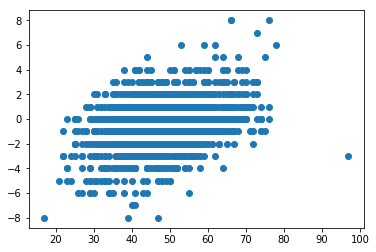

In [237]:
plt.scatter(poss_goals['awaypos'], poss_goals['away_team_goal'] - poss_goals['home_team_goal'])
plt.show()

In [238]:
poss_goals.groupby('diff').agg({'awaypos':np.mean}).reset_index()

,diff,awaypos
0,-8,34.333333
1,-7,40.500000
2,-6,35.769231
3,-5,36.200000
4,-4,42.000000
5,-3,44.677419
6,-2,46.039216
7,-1,48.697248
8,0,49.227666
9,1,49.661224


In [262]:
goals_data = goals_df.merge(data[['match_api_id', 'season']]).groupby(['season', 'player1']).agg({'elapsed': 'count'}).reset_index()
goals_data.columns = ['season', 'player_id', 'goals']

In [266]:
assists = goals_df.merge(data[['match_api_id', 'season']]).groupby(['season', 'player2']).agg({'elapsed': 'count'}).reset_index()
assists.columns = ['season', 'player_id', 'assists']

In [251]:
shoton = shoton_df.merge(data[['match_api_id', 'season']]).groupby(['season', 'player1']).agg({'elapsed': 'count'}).reset_index()
shoton.columns = ['season', 'player_id', 'shotson']

In [256]:
shotoff = shotoff_df.merge(data[['match_api_id', 'season']]).groupby(['season', 'player1']).agg({'elapsed': 'count'}).reset_index()
shotoff.columns = ['season', 'player_id', 'shotsoff']

In [271]:
fouls_commit = foulcommit_df.merge(data[['match_api_id', 'season']]).groupby(['season', 'player1']).agg({'elapsed': 'count'}).reset_index()
fouls_commit.columns = ['season', 'player_id', 'fouls_committed']

In [259]:
fouls_drawn = foulcommit_df.merge(data[['match_api_id', 'season']]).groupby(['season', 'player2']).agg({'elapsed': 'count'}).reset_index()
fouls_drawn.columns = ['season', 'player_id', 'fouls_drawn']

In [285]:
player_data = goals_data.merge(assists, on = ['season', 'player_id'], how = 'outer').\
merge(shoton, on = ['season', 'player_id'], how = 'outer'). \
merge(shotoff, on = ['season', 'player_id'], how = 'outer').\
merge(fouls_commit, on = ['season', 'player_id'], how = 'outer'). \
merge(fouls_drawn, on = ['season', 'player_id'], how = 'outer').fillna(0)

player_data['player_id'] = player_data['player_id'].astype(int)

In [282]:
lkp = pd.read_sql_query("select player_api_id player_id, player_name name from player", conn)

In [286]:
player_data = player_data.merge(lkp, on = 'player_id')

In [288]:
player_data[player_data['name'] == 'Lionel Messi']

,season,player_id,goals,assists,shotson,shotsoff,fouls_committed,fouls_drawn,name
250,2008/2009,30981,25.0,8.0,46.0,40.0,24.0,76.0,Lionel Messi
251,2009/2010,30981,35.0,9.0,70.0,45.0,25.0,60.0,Lionel Messi
252,2010/2011,30981,32.0,17.0,62.0,47.0,17.0,50.0,Lionel Messi
253,2011/2012,30981,52.0,15.0,96.0,58.0,22.0,75.0,Lionel Messi
254,2012/2013,30981,46.0,0.0,0.0,0.0,0.0,0.0,Lionel Messi
255,2013/2014,30981,29.0,6.0,4.0,2.0,1.0,6.0,Lionel Messi
256,2014/2015,30981,46.0,18.0,84.0,61.0,25.0,89.0,Lionel Messi
257,2015/2016,30981,30.0,16.0,77.0,52.0,15.0,63.0,Lionel Messi
